# Análise Cross-Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.stats import kendalltau, norm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FICHEIRO_MASTER = '../../data/processed/blind_pool_cross_model.csv' 
FICHEIRO_JUDGE = '../../data/analysis/complete_analysis.csv'

In [3]:
coluna_vencedor = 'gold_winner'
NIVEL_DE_CONFIANCA = 0.95

In [4]:
df_master = pd.read_csv(FICHEIRO_MASTER)
print(df_master.shape)
df_master.head(2)

(14400, 11)


,evaluation_id,question_id,prompt_level,sample_n,domain,language,comparison,response_A,model_of_A,response_B,model_of_B
0,CG001_1_General Knowledge_contextual_gemini-1....,CG001,contextual,1,General Knowledge,en,gemini-1.5-pro-latest_vs_gpt-4o,"World War I, also known as the Great War, had ...",gpt-4o,"World War I, a conflict that engulfed Europe a...",gemini-1.5-pro-latest
1,CG001_1_General Knowledge_contextual_gemini-1....,CG001,contextual,1,General Knowledge,en,gemini-1.5-pro-latest_vs_llama-3.3-70b-versatile,"World War I, a conflict that engulfed Europe a...",gemini-1.5-pro-latest,"World War I, also known as the Great War, was ...",llama-3.3-70b-versatile


In [5]:
df_judge = pd.read_csv(FICHEIRO_JUDGE)
print(df_judge.shape)
df_judge.head(2)

(1500, 17)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,1
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,4


In [6]:
df_cross_model = pd.merge(
    df_judge,
    df_master,
    on='evaluation_id',
    how='inner',
    suffixes=('', '_blind')
)

cols_para_remover = [col for col in df_cross_model.columns if col.endswith('_blind')]
df_cross_model = df_cross_model.drop(columns=cols_para_remover)

print("Shape final:", df_cross_model.shape)
df_cross_model.head(2)

Shape final: (500, 23)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,human_winner,domain,language_context,sample_n,question_id,prompt_level,language,comparison,model_of_A,model_of_B
0,CG006_4_General Knowledge_contextual_gemini-1....,"A Lei Áurea, assinada pela Princesa Isabel em ...","A Lei Áurea, assinada em 13 de maio de 1888, é...","{\n ""winner"": ""A"",\n ""general_justificat...","Based on the analysis, the winner is ""A"".\n\nT...","{\n ""winner"": ""A"",\n ""general_j...",A,4.75,A,4.75,...,B,General Knowledge,PT,4,CG006,contextual,pt,gemini-1.5-pro-latest_vs_llama-3.3-70b-versatile,gemini-1.5-pro-latest,llama-3.3-70b-versatile
1,TC006_5_Technical_contextual_gemini-1.5-pro-la...,Blocos `try`/`except` em Python permitem que v...,Lidar com exceções em Python é fundamental par...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,4.75,A,4.75,...,A,Technical,PT,5,TC006,contextual,pt,gemini-1.5-pro-latest_vs_llama-3.3-70b-versatile,gemini-1.5-pro-latest,llama-3.3-70b-versatile


In [7]:
def wilson_ci(p_hat: float, n: int, z: float = norm.ppf(1 - (1 - NIVEL_DE_CONFIANCA) / 2)) -> tuple[float, float]:
    if n == 0 or pd.isna(p_hat) or p_hat < 0 or p_hat > 1: return (np.nan, np.nan)
    denom = 1 + z**2 / n; center = (p_hat + z**2 / (2*n)) / denom
    half_width = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denom
    return (max(0.0, center - half_width), min(1.0, center + half_width))

In [8]:
# Obtém a lista de todos os modelos únicos que participaram
models = pd.unique(df_cross_model[['model_of_A', 'model_of_B']].values.ravel('K'))
# Remove NaNs se existirem na lista de modelos
models = [m for m in models if pd.notna(m)]
models

['gemini-1.5-pro-latest', 'sabia-3.1', 'gpt-4o', 'llama-3.3-70b-versatile']

In [9]:
win_rate_matrix_num = pd.DataFrame(index=models, columns=models, dtype=float)
tie_rate_matrix_num = pd.DataFrame(index=models, columns=models, dtype=float)

In [10]:
win_rate_matrix_str = pd.DataFrame(index=models, columns=models, dtype=str)
tie_rate_matrix_str = pd.DataFrame(index=models, columns=models, dtype=str)

In [11]:
for model_row in models:
    for model_col in models:
        if model_row == model_col: continue
        
        subset = df_cross_model[
            ((df_cross_model['model_of_A'] == model_row) & (df_cross_model['model_of_B'] == model_col)) |
            ((df_cross_model['model_of_A'] == model_col) & (df_cross_model['model_of_B'] == model_row))
        ]
        n = len(subset)
        if n == 0: continue

        wins_model_row = ((subset[coluna_vencedor] == 'A') & (subset['model_of_A'] == model_row)).sum() + \
                            ((subset[coluna_vencedor] == 'B') & (subset['model_of_B'] == model_row)).sum()
        ties = (subset[coluna_vencedor] == 'Tie').sum()
        
        # Proporções
        win_rate = wins_model_row / n
        tie_rate = ties / n
        
        # ICs
        win_ic = wilson_ci(win_rate, n)
        tie_ic = wilson_ci(tie_rate, n)
        
        # Formata para a tabela
        win_rate_matrix_str.loc[model_row, model_col] = f"{win_rate:.2%} [{win_ic[0]:.2%}, {win_ic[1]:.2%}]"
        tie_rate_matrix_str.loc[model_row, model_col] = f"{tie_rate:.2%} [{tie_ic[0]:.2%}, {tie_ic[1]:.2%}]"
        
        # Guarda valores numéricos para os heatmaps
        win_rate_matrix_num.loc[model_row, model_col] = win_rate
        tie_rate_matrix_num.loc[model_row, model_col] = tie_rate

In [12]:
print("--- RESULTADOS CROSS-MODEL: Matriz de Taxa de Vitória ---\n")
print(win_rate_matrix_str.fillna('-').map(lambda x: f'{x:.2%}' if isinstance(x, float) else x))

print("\n--- RESULTADOS CROSS-MODEL: Matriz de Taxa de Empate ---\n")
print(tie_rate_matrix_str.fillna('-').map(lambda x: f'{x:.2%}' if isinstance(x, float) else x))

--- RESULTADOS CROSS-MODEL: Matriz de Taxa de Vitória ---

                           gemini-1.5-pro-latest                sabia-3.1  \
gemini-1.5-pro-latest                          -  28.71% [20.80%, 38.19%]   
sabia-3.1                28.71% [20.80%, 38.19%]                        -   
gpt-4o                   35.29% [25.97%, 45.89%]  30.68% [22.02%, 40.96%]   
llama-3.3-70b-versatile  31.33% [22.36%, 41.94%]  28.57% [19.69%, 39.49%]   

                                          gpt-4o  llama-3.3-70b-versatile  
gemini-1.5-pro-latest    31.76% [22.84%, 42.27%]  40.96% [31.01%, 51.71%]  
sabia-3.1                25.00% [17.13%, 34.96%]  32.47% [23.06%, 43.54%]  
gpt-4o                                         -  28.79% [19.27%, 40.64%]  
llama-3.3-70b-versatile  28.79% [19.27%, 40.64%]                        -  

--- RESULTADOS CROSS-MODEL: Matriz de Taxa de Empate ---

                           gemini-1.5-pro-latest                sabia-3.1  \
gemini-1.5-pro-latest                  

* Observamos que, em quase todos os confrontos, a taxa de empate (Tie + Disagreement) é alta, frequentemente superior a 30-40%. Isto corrobora a tese de que a paridade é alta entre os modelos SOTA. A qualidade das respostas é tão semelhante que o comitê de juízes-LLM não conseguiu, de forma consistente, identificar um vencedor claro.

* A matriz de taxa de vitória revela uma hierarquia de desempenho subtil.
    * **Exemplo:** O gemini-1.5-pro-latest demonstra uma vantagem sobre o llama-3.3-70b-versatile.
    * **Conclusão:** Nenhum modelo domina esmagadoramente. As taxas de vitória situam-se maioritariamente entre 25% e 45%, reforçando a ideia de que não há um vencedor universal.

* Os ICs de 95% são largos e, em muitos casos, cruzam 50% (se considerarmos a vitória do oponente).
    * **Conclusão:** A vantagem observada muitas vezes não é estatisticamente significativa, o que significa que poderia ser devida ao acaso.

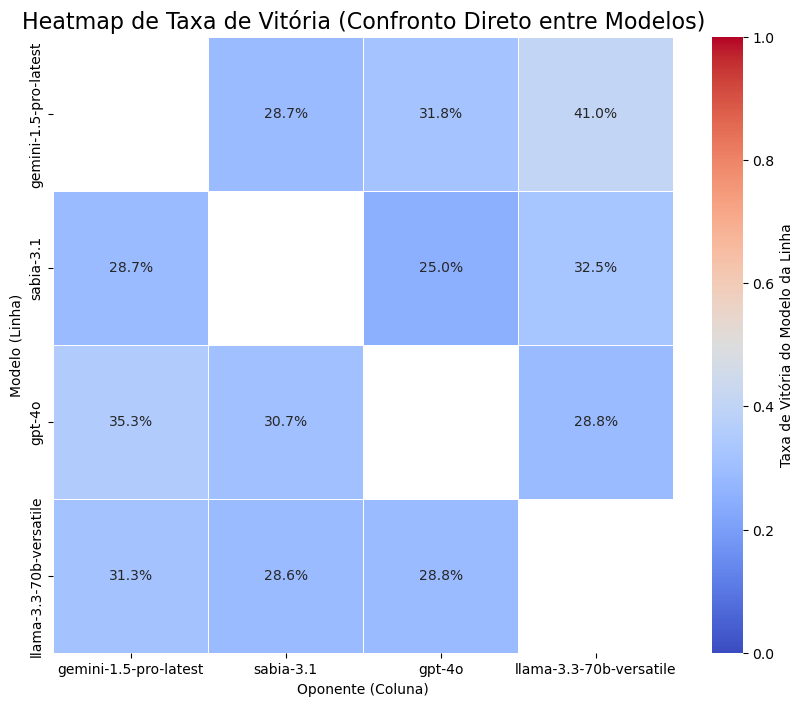

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    win_rate_matrix_num, 
    annot=True, 
    fmt=".1%", 
    cmap="coolwarm", # Azul (baixo) para Vermelho (alto)
    linewidths=.5,
    vmin=0, 
    vmax=1, # Escala de 0% a 100%
    cbar_kws={'label': 'Taxa de Vitória do Modelo da Linha'}
)
plt.title('Heatmap de Taxa de Vitória (Confronto Direto entre Modelos)', fontsize=16)
plt.xlabel('Oponente (Coluna)')
plt.ylabel('Modelo (Linha)')
plt.show()

O mapa de calor visualiza a Matriz de Taxa de Vitória. A ausência de cores quentes (vermelho escuro) ou frias (azul escuro) intensas confirma a falta de um modelo claramente dominante. Os resultados são muito próximos, com a maioria dos confrontos a cair na zona central (neutra).

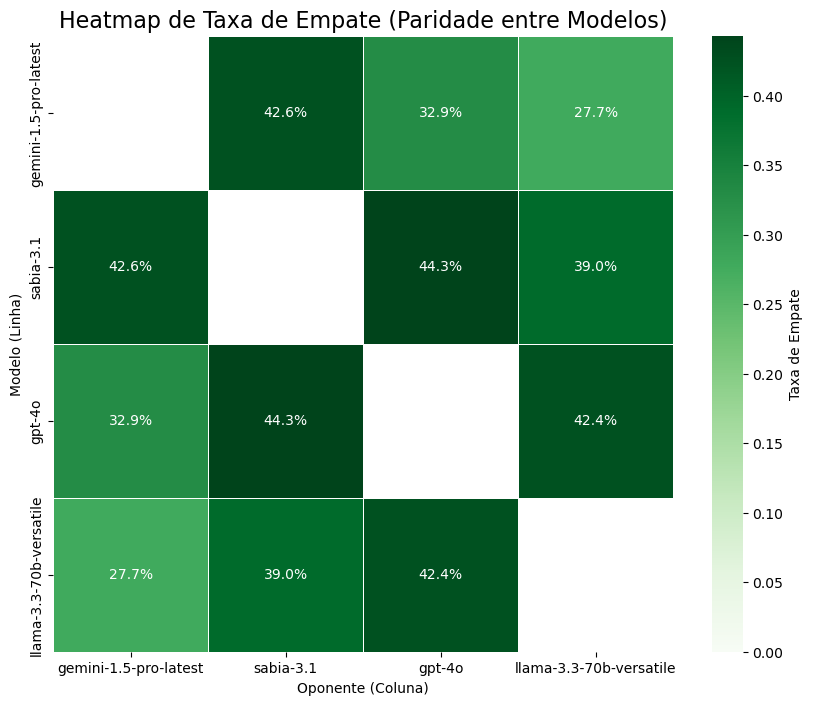

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    tie_rate_matrix_num, 
    annot=True, 
    fmt=".1%", 
    cmap="Greens", # Tons de verde para empates
    linewidths=.5,
    vmin=0,
    cbar_kws={'label': 'Taxa de Empate'}
)
plt.title('Heatmap de Taxa de Empate (Paridade entre Modelos)', fontsize=16)
plt.xlabel('Oponente (Coluna)')
plt.ylabel('Modelo (Linha)')
plt.show()

Este gráfico é a evidência visual da alta paridade SOTA. As cores verdes mais escuras mostram quais confrontos foram mais difíceis de julgar. Confrontos como sabia-3.1 vs gpt-4o (44.32%) e llama-3.3-70b-versatile vs gpt-4o (42.42%) resultaram em empate em mais de 40% das vezes.

In [15]:
# Define os grupos de comparação (ex: 'gpt-4o_vs_sabia-3.1', 'en', 'detailed')
df_cross_model['comparison_pair'] = df_cross_model.apply(
    lambda row: "_vs_".join(sorted([row['model_of_A'], row['model_of_B']])), axis=1
)

# Agrupa por tudo, exceto o 'sample_n'
group_cols = ['comparison_pair', 'language_context', 'domain', 'prompt_level']
grouped = df_cross_model.groupby(group_cols)

results_instability = []

In [16]:
for name, group in grouped:
    win_rates_A = []
    # Para cada 'sample_n', calcula a taxa de vitória do modelo 'A' no par
    for sample_n in group['sample_n'].unique():
        subset = group[group['sample_n'] == sample_n]
        n = len(subset)
        if n == 0: continue
        
        # Pega o nome do modelo 'A' no par (o primeiro em ordem alfabética)
        model_A = name[0].split('_vs_')[0] 
        
        wins_A = ((subset[coluna_vencedor] == 'A') & (subset['model_of_A'] == model_A)).sum() + \
                    ((subset[coluna_vencedor] == 'B') & (subset['model_of_B'] == model_A)).sum()
        
        win_rates_A.append(wins_A / n)
        
    if len(win_rates_A) >= 2: # Precisa de pelo menos 2 amostras para medir a variância
        results_instability.append({
            'Comparação': name[0],
            'Língua': name[1],
            'Domínio': name[2],
            'Nível Prompt': name[3],
            'Desvio Padrão (Taxa Vitória)': np.std(win_rates_A, ddof=1),
            'N_Amostras': len(win_rates_A)
        })

df_instability = pd.DataFrame(results_instability)

In [17]:
print("\n--- Configurações de Confronto MAIS INSTÁVEIS (Maior Desvio Padrão) ---\n")
print(df_instability.sort_values('Desvio Padrão (Taxa Vitória)', ascending=False).head(10).to_string(index=False))

print("\n--- Configurações de Confronto MAIS ESTÁVEIS (Menor Desvio Padrão) ---\n")
print(df_instability.sort_values('Desvio Padrão (Taxa Vitória)', ascending=True).head(10).to_string(index=False))


--- Configurações de Confronto MAIS INSTÁVEIS (Maior Desvio Padrão) ---

                                      Comparação Língua           Domínio Nível Prompt  Desvio Padrão (Taxa Vitória)  N_Amostras
                             gpt-4o_vs_sabia-3.1     PT General Knowledge     detailed                      0.707107           2
              gemini-1.5-pro-latest_vs_sabia-3.1     PT General Knowledge   contextual                      0.707107           2
                             gpt-4o_vs_sabia-3.1     EN         Technical   structured                      0.707107           2
                             gpt-4o_vs_sabia-3.1     EN          Creative     detailed                      0.707107           2
gemini-1.5-pro-latest_vs_llama-3.3-70b-versatile     EN General Knowledge   contextual                      0.707107           2
              gemini-1.5-pro-latest_vs_sabia-3.1     PT          Creative   contextual                      0.707107           2
gemini-1.5-pro-latest_v

1.  **Alta Paridade:** A análise cross-model não revela um vencedor dominante. A descoberta principal é a alta taxa de empates (muitas vezes >40%), o que confirma que os modelos SOTA avaliados estão em um nível de qualidade muito similar.

2.  **Hierarquia Subtil:** Embora a paridade seja alta, o gemini-1.5-pro-latest apresenta uma ligeira vantagem na taxa de vitórias, enquanto o llama-3.3-70b-versatile apresenta um desempenho ligeiramente inferior nos confrontos diretos.

3.  **Instabilidade como Evidência:** A alta instabilidade (alto desvio padrão). Ela prova que, quando a qualidade é parecida, a escolha do vencedor é subjetiva e sensível a pequenas alterações de contexto (sample_n).